## Rotation Correction Model Training

Some of the images in the training set are rotated in multiples of 90 degrees, which need to be corrected before being used in training or inference.  Ideally, detecting and correcting this would be much faster than the general classification task, but should it should be doable with a small dataset since all the images are of buildings.  Most images have strong vertical edges and sky in the background.  Seems like we should be able to achieve 100% accuracy.



### Summary of Results

Two different techniques were attempted, both of them were aiming for simplicity over operational speed/efficiency:

1. Straight logistic regression on pixel values in image resized to 64x64x3
2. Xception (pre-trained network) feature extraction.  Use logistic regression on 10x10x2048 output

The straight logistic regression got about 95% overall accuracy and precision on all four rotation settings.  This was impressive, but I figured we could get closer to 100%.

I had a few more ideas, but I ended up getting satisfactory results with #2 above, so I didn't both trying anything else.  It uses the Xception network as a feature extractor, using the non-global-averaged output as input to a logistic regression.  This classifier took a while to train (200k inputs per image), but only misclassified 3 out of 600 images.  Here's the confusion matrix:

```
[[146   0   0   0]
 [  0 145   1   0]
 [  0   0 145   1]
 [  0   1   0 145]]
 ```

The downside is that it used the 20M parameter Xception network as the feature extractor, which is likely what we'll use for the full classification task.  This is not fast, and there's surely a better way.  A quick stab using a 50k-param CNN didn't break 98%.  

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import numpy as np
import seaborn as sns
 
import tensorflow as tf
from tensorflow import keras

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
IMG_ROTATE_SIZE = (64, 64)
IMG_ROTATE_SIZE_3D = IMG_ROTATE_SIZE + (3,)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from load_and_preprocess_data import *
from image_utilities import ImageUtilities

In [5]:
def input_generator_train_rotation(all_train_info, file_map, img_size, preproc_func=lambda x: x):
    """
    The train_info object has all train and test samples/filenames.  We use it just for the
    sampling probabilities.
    """
    
    def out_generator():
        total_ct = sum([len(file_map[c]) for c in file_map.keys()])
        for i in range(total_ct):
            img_path, country_idx = all_train_info.sample_filename('train')
            img = ImageUtilities.load_image(img_path, preproc_func)
            #img = cv2.resize(img, img_size)
            img = ImageUtilities.augment_image(img, resize_to=img_size)
            num_clicks = np.random.choice(4)
            img = ImageUtilities.rotate_image_90deg(img, clicks=num_clicks)
            ans = np.zeros(shape=(4,), dtype='float32')
            ans[num_clicks] = 1.0
            yield (img, ans)
        
    return out_generator
        
    
def generator_to_dataset(gener_obj, img_size_3d, batch_size=64):
    """
    Take a generator produced above and wrap it in a tf.data.Dataset.  
    from_generator requires and image size, hence why it is passed in again.
    """
    out_dataset = tf.data.Dataset.from_generator( 
        gener_obj,
        (tf.float64, tf.float64), 
        (tf.TensorShape(img_size_3d), tf.TensorShape((4,))))

    if batch_size:
        out_dataset = out_dataset.batch(batch_size)
        
    return out_dataset
    
def create_test_dataset(file_map, img_size_3d, preproc_func, batch_size=64):
    """
    This doesn't require the full train_info object, since it's not sampling
    """
    def generator_func():
        for c in file_map.keys():
            for img_path in file_map[c]:
                for r in range(4):
                    img = ImageUtilities.load_image(img_path, preproc_func)
                    img = cv2.resize(img, img_size_3d[:2])
                    img = ImageUtilities.rotate_image_90deg(img, clicks=r)
                    ans = np.zeros(shape=(4,), dtype='float32')
                    ans[r] = 1.0
                    yield (img, ans)
    
    return generator_to_dataset(generator_func, img_size_3d, batch_size)


def load_all_images_one_rotation(file_map, clicks=0, img_size=IMG_ROTATE_SIZE):
    """
    This loads all images into mem, only use this if img_size is appropriately small (i.e. 64x64)
    """
    all_imgs = []
    for country,fn_list in file_map.items():
        for fullpath in fn_list:
            orig_img = ImageUtilities.load_image(fullpath)
            resz_img = cv2.resize(orig_img, img_size)
            rotated = ImageUtilities.rotate_image_90deg(resz_img, clicks=clicks)
            all_imgs.append(rotated)
            
    out = np.stack(all_imgs)
    print(f'Full dataset for rotation, {clicks} clicks: {out.shape}')
    return (out, [clicks] * out.shape[0])


def load_all_images_all_rotations(file_map, img_size=IMG_ROTATE_SIZE):
    """
    This loads all images into mem, only use this if img_size is appropriately small (i.e. 64x64)
    """
    all_rotations = [load_all_images_one_rotation(file_map, i) for i in range(4)]
    all_imgs = np.concatenate([i[0] for i in all_rotations], axis=0)
    all_lbls = np.concatenate([i[1] for i in all_rotations], axis=0)
    print(f'Combined dataset shape: imgs~{all_imgs.shape}, lbls~{all_lbls.shape}')
    return (all_imgs, all_lbls)
    

In [6]:
train_folder = 'train_fixed_rotation' # manually-corrected images

In [7]:
train_info = TrainDataInfo(train_folder)
train_spl = train_info.traintest_splits[1]['train']
test_spl  = train_info.traintest_splits[1]['test']

Full dataset for rotation, 0 clicks: (145, 64, 64, 3)
Full dataset for rotation, 1 clicks: (145, 64, 64, 3)
Full dataset for rotation, 2 clicks: (145, 64, 64, 3)
Full dataset for rotation, 3 clicks: (145, 64, 64, 3)
Combined dataset shape: imgs~(580, 64, 64, 3), lbls~(580,)
Final test set: (580, 64, 64, 3)


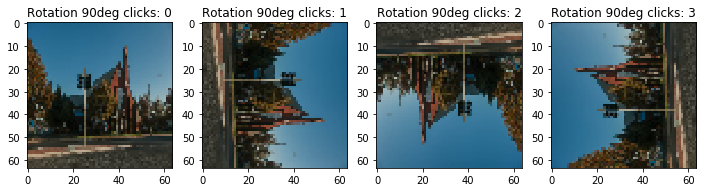

In [8]:
test_imgs, test_labels = load_all_images_all_rotations(test_spl)
num_test = int(test_imgs.shape[0] / 4)
print(f'Final test set: {test_imgs.shape}')
fig,axs = plt.subplots(1, 4, figsize=(12, 5))
for i in range(4):
    axs[i].imshow(test_imgs[i * num_test])
    axs[i].set_title(f'Rotation 90deg clicks: {test_labels[i * num_test]}')

Full dataset for rotation, 0 clicks: (569, 64, 64, 3)
Full dataset for rotation, 1 clicks: (569, 64, 64, 3)
Full dataset for rotation, 2 clicks: (569, 64, 64, 3)
Full dataset for rotation, 3 clicks: (569, 64, 64, 3)
Combined dataset shape: imgs~(2276, 64, 64, 3), lbls~(2276,)
Final train set: (2276, 64, 64, 3)


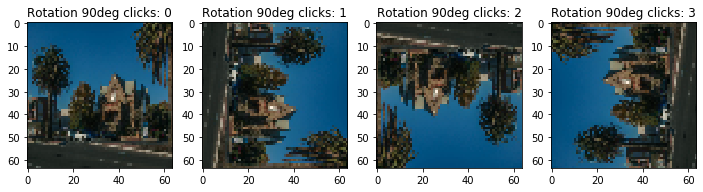

In [9]:
train_imgs, train_labels = load_all_images_all_rotations(train_spl)
num_train = int(train_imgs.shape[0] / 4)
print(f'Final train set: {train_imgs.shape}')
fig,axs = plt.subplots(1, 4, figsize=(12, 5))
for i in range(4):
    axs[i].imshow(train_imgs[i * num_train])
    axs[i].set_title(f'Rotation 90deg clicks: {train_labels[i * num_train]}')


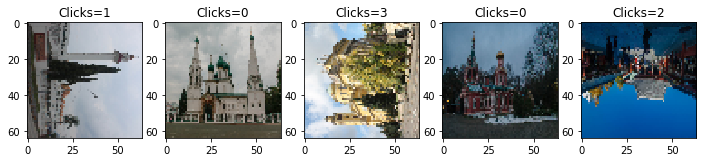

In [10]:
fig,axs = plt.subplots(1, 5, figsize=(12,7))
for i in range(5):
    idx = np.random.choice(train_imgs.shape[0])
    axs[i].imshow(train_imgs[idx])
    axs[i].set_title(f'Clicks={train_labels[idx]}')
    

In [11]:
# Flatten images for logistic regression
train_imgs_flat = train_imgs.reshape([train_imgs.shape[0], -1])
test_imgs_flat = test_imgs.reshape([test_imgs.shape[0], -1])
print(f'Flatted training data: {train_imgs_flat.shape}')
print(f'Flatted testing data: {test_imgs_flat.shape}')

Flatted training data: (2276, 12288)
Flatted testing data: (580, 12288)


In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=0.01)
logreg.fit(train_imgs_flat, train_labels)

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
pred_labels = logreg.predict(test_imgs_flat)
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print('Classification Report for the 4 different rotations/clicks')
print(sklearn.metrics.classification_report(test_labels, pred_labels))
print('Raw confusion matrix')
print(cm)
print("Not terrible, but I think we can do 100%")

Classification Report for the 4 different rotations/clicks
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       145
           1       0.95      0.95      0.95       145
           2       0.95      0.95      0.95       145
           3       0.95      0.95      0.95       145

    accuracy                           0.95       580
   macro avg       0.95      0.95      0.95       580
weighted avg       0.95      0.95      0.95       580

Raw confusion matrix
[[138   4   1   2]
 [  2 138   4   1]
 [  1   2 138   4]
 [  4   1   2 138]]
Not terrible, but I think we can do 100%


Mismatchs: (28, 1)


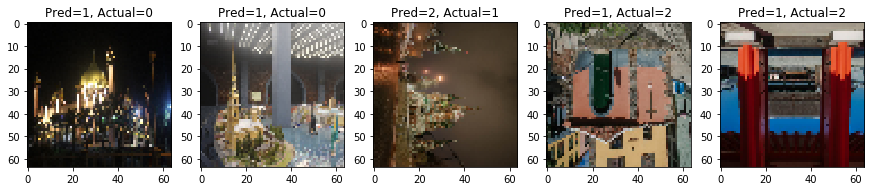

In [14]:
# Let's confirm that this isn't the result of some images not being labeled properly
mismatch = np.argwhere(test_labels != pred_labels)
print(f'Mismatchs: {mismatch.shape}')
fig,axs = plt.subplots(1,5, figsize=(15,5))
for i in range(5):
    idx = mismatch[i*5][0]
    axs[i].imshow(test_imgs[idx])
    axs[i].set_title(f'Pred={pred_labels[idx]}, Actual={test_labels[idx]}')

Not bad, but I think we can do better...

# Try Pre-trained Model Features

In [15]:
from tensorflow.keras.applications import Xception
fex_model = Xception(weights='imagenet', include_top=False)
print(f'Model Xception has {len(fex_model.layers)} layers')
fex_model.summary()

Model Xception has 132 layers
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_____________________________________________________________

In [16]:
xcept_in = fex_model.layers[0]
xcept_out = fex_model.layers[-1]

print(f'Xception model has IO shapes: {xcept_in.output_shape} -> {xcept_out.output_shape}')
print(f'It actually spits out 10x10x2048')

Xception model has IO shapes: [(None, None, None, 3)] -> (None, None, None, 2048)
It actually spits out 10x10x2048


In [17]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as xcept_preproc
xcept_input_shape = (299, 299)
xcept_input_shape_3d = (299, 299, 3)
batch_size = 64
igen = input_generator_train_rotation(
    train_info,
    train_spl,
    xcept_input_shape,
    preproc_func=xcept_preproc)

train_ds = generator_to_dataset(igen, xcept_input_shape_3d, batch_size=batch_size)

In [18]:
for batch in train_ds.take(3):
    print(batch[0].shape)

(64, 299, 299, 3)
(64, 299, 299, 3)
(64, 299, 299, 3)


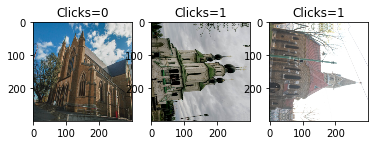

In [19]:
fig, axs = plt.subplots(1,3)
unpreproc = lambda x: x / 2.0 + 0.5
for i in range(3):
    idx = np.random.choice(batch_size)
    axs[i].imshow(unpreproc(batch[0][idx, :, :, :].numpy()))
    axs[i].set_title(f'Clicks={np.argmax(batch[1][idx])}')


In [20]:
# Extract features from TRAINING images using Xception network
fex_in, ans_out = [], []
for batch in train_ds.repeat(5):
    img_batch, ans_batch = batch 
    n_samples = img_batch.shape[0]
    fex_in.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
    ans_out.append(ans_batch.numpy())
    
# Concatenate all outputs (inputs and output), collapse output to integer labels for LogReg
xcept_train_features = np.concatenate(fex_in, axis=0)
xcept_train_labels = np.argmax(np.concatenate(ans_out, axis=0), axis=1)
print(f'Training features: {xcept_train_features.shape}')
print(f'Training labels: {xcept_train_labels.shape}')

Training features: (2845, 204800)
Training labels: (2845,)


In [21]:
# Extract features from TESTING images using Xception network
test_ds = create_test_dataset(test_spl, xcept_input_shape_3d, xcept_preproc, batch_size=64)
disp_imgs, fex_in, ans_out = [], [], []
for batch in test_ds:
    img_batch, ans_batch = batch 
    n_samples = img_batch.shape[0]
    disp_imgs.append(img_batch)
    fex_in.append(fex_model.predict_on_batch(img_batch).numpy().reshape([n_samples, -1]))
    ans_out.append(ans_batch.numpy())
    
xcept_test_imgs = np.concatenate(disp_imgs, axis=0)
xcept_test_features = np.concatenate(fex_in, axis=0)
xcept_test_labels = np.argmax(np.concatenate(ans_out, axis=0), axis=1)
print(f'Testing images: {xcept_test_imgs.shape}')
print(f'Testing features: {xcept_test_features.shape}')
print(f'Testing labels: {xcept_test_labels.shape}')

Testing images: (580, 299, 299, 3)
Testing features: (580, 204800)
Testing labels: (580,)


In [22]:
logreg = LogisticRegression(C=0.01)
logreg.fit(xcept_train_features, xcept_train_labels)

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## The Moment of Truth
Can we accurately determine the rotation of an image?

In [23]:
pred_labels = logreg.predict(xcept_test_features)
print('Classification Report:')
print(sklearn.metrics.classification_report(xcept_test_labels, pred_labels))
print('Confusion Matrix:')
cm = sklearn.metrics.confusion_matrix(xcept_test_labels, pred_labels)
print(cm)
      

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      0.98      0.99       145
           2       1.00      1.00      1.00       145
           3       0.98      1.00      0.99       145

    accuracy                           0.99       580
   macro avg       0.99      0.99      0.99       580
weighted avg       0.99      0.99      0.99       580

Confusion Matrix:
[[145   0   0   0]
 [  0 142   0   3]
 [  0   0 145   0]
 [  0   0   0 145]]


Mismatchs: (3, 1)
Probabilities: ['0.000', '0.138', '0.000', '0.862']
Probabilities: ['0.000', '0.479', '0.000', '0.520']
Probabilities: ['0.001', '0.260', '0.005', '0.734']


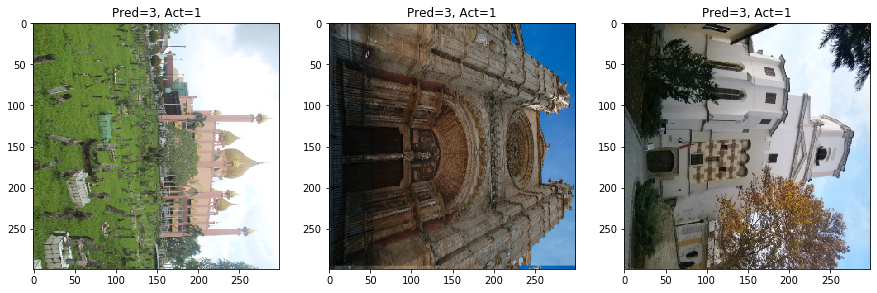

In [24]:
# Let's confirm that this isn't the result of some images not being labeled properly
mismatch = np.argwhere(xcept_test_labels != pred_labels)
pred_probs = logreg.predict_proba(xcept_test_features)
print(f'Mismatchs: {mismatch.shape}')
fig,axs = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    idx = mismatch[i][0]
    axs[i].imshow(xcept_test_imgs[idx] / 2.0 + 0.5)
    axs[i].set_title(f'Pred={pred_labels[idx]}, Act={xcept_test_labels[idx]}')
    print('Probabilities:', [f'{p:.3f}' for p in pred_probs[idx].tolist()])


# Save the model and create a wrapper for it.
Total of 3 wrong predictions out of 568, approx 0.5%.  I'm not sure how it got the 3 wrong, as they look pretty obvious to me, but I'll call this satisfactory for this exercise.

In [25]:
import pickle
MODEL_FILENAME = 'rotation_detect_xcept_logreg.clf'
with open(MODEL_FILENAME, 'wb') as fwrite:
    pickle.dump(logreg, fwrite)
    
with open(MODEL_FILENAME, 'rb') as fread:
    logreg = pickle.load(fread)

try:
    import boto3
    s3_client = boto3.client('s3')
    print(f'Uploading model to S3: {MODEL_FILENAME}')
    s3_client.upload_file(MODEL_FILENAME, 'acr-toptal-codingproj', MODEL_FILENAME, ExtraArgs={'ACL': 'public-read'})
    print(f'Success!')
except Exception as e:
    print(f'Error uploading to S3, skipping: {str(e)}')

Uploading model to S3: rotation_detect_xcept_logreg.clf
Success!


### Create a Wrapper
This will be an importable class that is a one-stop shop for detecting & fixing rotated images

In [31]:
%%writefile rotation_correction.py
import cv2
import os
import pickle
import numpy as np
import tensorflow as tf
import subprocess
from image_utilities import ImageUtilities
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input

class RotationCorrection:
    DEFAULT_MODEL_FILE = 'rotation_detect_xcept_logreg.clf'
    
    def __init__(self, logreg_model_file=None):
        """
        The logistic regression model will be downloaded from S3 if it doesn't exist locally (yet)
        """
        # I like to put all the members of the class at the top
        self.model_file = logreg_model_file if logreg_model_file else self.DEFAULT_MODEL_FILE
        self.xception_no_head = None
        self.rotate_detector_head = None
        
        # If the model file does not exist locally, download it
        if self.model_file is None or not os.path.exists(self.model_file):
            # Download with wget (to avoid the caller needing boto3 library)
            try:
                s3obj = f'https://acr-toptal-codingproj.s3.amazonaws.com/{self.DEFAULT_MODEL_FILE}'
                print(f'Attempting to download: {s3obj}')
                subprocess.check_call(['wget', s3obj])
                print(f'Successful!')
            except Exception as e:
                raise 
                
            self.model_file = s3obj.split('/')[-1]
        else:
            print(f'Using already-downloaded model file: {self.model_file}')
                                    
        self.xception_no_head = Xception(weights='imagenet', include_top=False)
        with open(self.model_file, 'rb') as fread:
            self.rotate_detector_head = pickle.load(fread)
        
        
    def fix_one_image(self, img):
        """
        This assumes you've already applied the preprocessing function to it
        """
        
        orig_shape = img.shape
        
        # First squeeze it down to 3D (if necessary) for cv2 to resize it
        if len(orig_shape) == 4:
            img = np.squeeze(img, axis=0)
            
        # If it's not currently the right size, resize it
        if img.shape[:2] != (299, 299):
            img = cv2.resize(img, (299, 299))
            
        # We need to (re-add) the fourth dim to pass it like a batch (of size=1) to Xception
        img = np.expand_dims(img, axis=0)
        
        # Apply the classifier
        xcept_out = self.xception_no_head.predict(img).reshape([1, -1])
        
        num_clicks = self.rotate_detector_head.predict(xcept_out)[0]
        if num_clicks > 0:
            print(f'Image {img.shape} was rotated {num_clicks} clicks.  Rotating it to normal orientation.')
            img = np.squeeze(img, axis=0)
            img = ImageUtilities.rotate_image_90deg(img, -num_clicks)
            
        if len(orig_shape) == 3 and len(img.shape) == 4:
            img = np.squeeze(img, axis=0)
            
        if len(orig_shape) == 4 and len(img.shape) == 3:
            img = np.expand_dims(img, axis=0)
            
        return img, num_clicks
    

Overwriting rotation_correction.py


In [32]:
from rotation_correction import RotationCorrection

In [33]:
rcorrect = RotationCorrection()

Attempting to download: https://acr-toptal-codingproj.s3.amazonaws.com/rotation_detect_xcept_logreg.clf
Successful!


## Test the Wrapper
This will be slow because we process one image at a time

Image (1, 299, 299, 3) was rotated 1 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 2 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 3 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 1 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 2 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 3 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 1 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 2 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 3 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 1 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 2 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was rotated 3 clicks.  Rotating it to normal orientation.
Image (1, 299, 299, 3) was r

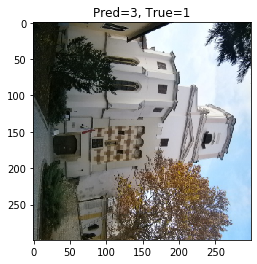

In [34]:
accum_pred, accum_true = [], []
for batch in test_ds:
    for i in range(batch[0].shape[0]):
        true_clicks = np.argmax(batch[1][i].numpy())
        
        fixed_img, pred_clicks = rcorrect.fix_one_image(batch[0][i, :, :, :])
        
        accum_pred.append(pred_clicks)
        accum_true.append(true_clicks)
        
        if pred_clicks != true_clicks:
            plt.imshow(batch[0][i, :, :, :] / 2.0 + 0.5)
            plt.title(f'Pred={pred_clicks}, True={true_clicks}')
        

In [35]:
print(sklearn.metrics.classification_report(accum_true, accum_pred))
print("Confusion Matrix")
print(sklearn.metrics.confusion_matrix(accum_true, accum_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       145
           1       1.00      0.98      0.99       145
           2       1.00      1.00      1.00       145
           3       0.98      1.00      0.99       145

    accuracy                           0.99       580
   macro avg       0.99      0.99      0.99       580
weighted avg       0.99      0.99      0.99       580

Confusion Matrix
[[145   0   0   0]
 [  0 142   0   3]
 [  0   0 145   0]
 [  0   0   0 145]]


### Looks like our .py wrapper functions work!